In [74]:
import numpy as np
import pandas as pd
from scipy.sparse import load_npz, hstack, csr_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns

Make sure preprocessing and word feature matrix notebooks are already run, so that we have the necessary matrices saved

In [75]:
X1 = load_npz("X1_word_matrix.npz")
X2 = load_npz("X2_word_matrix.npz")

Y1 = np.load("Y1_labels.npy")
Y2 = np.load("Y2_labels.npy")

F1 = pd.read_parquet("F1_features.parquet")
F2 = pd.read_parquet("F2_features.parquet")

print(f"X1 shape: {X1.shape}, Y1 shape: {Y1.shape}, F1 shape: {F1.shape}")
print(f"X2 shape: {X2.shape}, Y2 shape: {Y2.shape}, F2 shape: {F2.shape}")

X1 shape: (6334, 50000), Y1 shape: (6334, 10), F1 shape: (6334, 7)
X2 shape: (6334, 50000), Y2 shape: (6334, 10), F2 shape: (6334, 7)


In [76]:
# load original data to get genre names
first_df = pd.read_parquet("cleaned_data_first.parquet")

mlb = MultiLabelBinarizer()
mlb.fit(first_df["genre"])
genre_names = list(mlb.classes_)

print("Genre names:")
for i, name in enumerate(genre_names):
    print(f"  {i}: {name}")

Genre names:
  0: adult
  1: adventure
  2: childrens
  3: classics
  4: fantasy
  5: historical-fiction
  6: literary-fiction
  7: mystery
  8: romance
  9: science-fiction


In [77]:
F1_sparse = csr_matrix(F1.values) # convert to sparse 
F2_sparse = csr_matrix(F2.values)

X1_combined = hstack([X1, F1_sparse])
X2_combined = hstack([X2, F2_sparse])

print(X1_combined.shape)
print(X2_combined.shape)

(6334, 50007)
(6334, 50007)


In [78]:
# set up eventual 10-fold cross validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

In [98]:
def train_and_evaluate_fold(X_train, Y_train, X_test, Y_test, genre_names):
    # train one classifier per genre, in order
    classifiers = {}
    for i in range(len(genre_names)):
        y_train_binary = Y_train[:, i]
        classifier = MultinomialNB(alpha=1.0)
        classifier.fit(X_train, y_train_binary)
        classifiers[genre_names[i]] = classifier
    
    # make predictions
    Y_pred = np.zeros_like(Y_test) # make new array of correct size 
    for i, genre_name in enumerate(genre_names):
        classifier = classifiers[genre_name]
        Y_pred[:, i] = classifier.predict(X_test)

    # old accuracy: majority-correct accuracy
    # correct_counts = np.sum(Y_test == Y_pred, axis=1)
    # total_labels = Y_test.shape[1]
    # majority_correct = np.sum(correct_counts > ((total_labels + 1) / 2)) / len(Y_test)
    
    # second accuracy: count example as correct if we got at least half of its positive labels
    # correct_examples = 0
    # for i in range(len(Y_test)):
    #     actual_positives = np.sum(Y_test[i] == 1)
    #     if actual_positives > 0:
    #         correct_positives = np.sum((Y_test[i] == 1) & (Y_pred[i] == 1))
    #         if correct_positives >= actual_positives / 2:
    #             correct_examples += 1
    # majority_correct = correct_examples / len(Y_test)
    
    # third accuracy: count example as correct if we got at least one of its positive labels
    correct_examples = 0
    for i in range(len(Y_test)):
        actual_positives = np.sum(Y_test[i] == 1)
        if actual_positives > 0:
            correct_positives = np.sum((Y_test[i] == 1) & (Y_pred[i] == 1))
            if correct_positives >= 1:
                correct_examples += 1
    majority_correct = correct_examples / len(Y_test)
    
    # micro: actual global f1 score 
    # macro: average of per-genre f1 scores  
    micro_f1 = f1_score(Y_test, Y_pred, average='micro', zero_division=0)
    macro_f1 = f1_score(Y_test, Y_pred, average='macro', zero_division=0)
    
    # per-genre metrics
    genre_metrics = {}
    for i, genre_name in enumerate(genre_names):
        y_true = Y_test[:, i]
        y_pred = Y_pred[:, i]
        
        genre_metrics[genre_name] = {
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall': recall_score(y_true, y_pred, zero_division=0),
            'f1': f1_score(y_true, y_pred, zero_division=0),
            'accuracy': accuracy_score(y_true, y_pred)
        }
    
    return {
        'majority_accuracy': majority_correct,
        'micro_f1': micro_f1,
        'macro_f1': macro_f1,
        'genre_metrics': genre_metrics
    }

run 10-fold cv on dataset 1 (first 1000 sentences)

In [99]:
dataset1_results = []

for fold_idx, (train_idx, test_idx) in enumerate(kfold.split(X1_combined), 1):
    X_train_fold = X1_combined[train_idx]
    Y_train_fold = Y1[train_idx]
    X_test_fold = X1_combined[test_idx]
    Y_test_fold = Y1[test_idx]
    
    fold_results = train_and_evaluate_fold(X_train_fold, Y_train_fold, 
                                           X_test_fold, Y_test_fold, genre_names)
    fold_results['fold'] = fold_idx
    dataset1_results.append(fold_results)
    
    print(f"completed fold {fold_idx}/10")

completed fold 1/10
completed fold 2/10
completed fold 2/10
completed fold 3/10
completed fold 3/10
completed fold 4/10
completed fold 4/10
completed fold 5/10
completed fold 5/10
completed fold 6/10
completed fold 6/10
completed fold 7/10
completed fold 7/10
completed fold 8/10
completed fold 8/10
completed fold 9/10
completed fold 9/10
completed fold 10/10
completed fold 10/10


In [100]:
dataset2_results = []

for fold_idx, (train_idx, test_idx) in enumerate(kfold.split(X2_combined), 1):
    X_train_fold = X2_combined[train_idx]
    Y_train_fold = Y2[train_idx]
    X_test_fold = X2_combined[test_idx]
    Y_test_fold = Y2[test_idx]
    
    fold_results = train_and_evaluate_fold(X_train_fold, Y_train_fold, 
                                           X_test_fold, Y_test_fold, genre_names)
    fold_results['fold'] = fold_idx
    dataset2_results.append(fold_results)
    
    print(f"completed fold {fold_idx}/10")

completed fold 1/10
completed fold 2/10
completed fold 2/10
completed fold 3/10
completed fold 3/10
completed fold 4/10
completed fold 4/10
completed fold 5/10
completed fold 5/10
completed fold 6/10
completed fold 6/10
completed fold 7/10
completed fold 7/10
completed fold 8/10
completed fold 8/10
completed fold 9/10
completed fold 9/10
completed fold 10/10
completed fold 10/10


In [101]:
def aggregate_results(results, dataset_name):
    majority_accs = [r['majority_accuracy'] for r in results]
    micro_f1s = [r['micro_f1'] for r in results]
    macro_f1s = [r['macro_f1'] for r in results]
    
    print(f"\n{dataset_name} Results:")
    # print(f"  Accuracy: {np.mean(majority_accs):.3f} ± {np.std(majority_accs):.3f}")
    # print(f"  Micro F1: {np.mean(micro_f1s):.3f} ± {np.std(micro_f1s):.3f}")
    # print(f"  Macro F1: {np.mean(macro_f1s):.3f} ± {np.std(macro_f1s):.3f}")
    print(f"  Accuracy: {np.mean(majority_accs):.3f}")
    print(f"  Micro F1: {np.mean(micro_f1s):.3f}")
    print(f"  Macro F1: {np.mean(macro_f1s):.3f}")
    
    print(f"Per-Genre Metrics:")
    genre_aggregated = {}
    for genre in genre_names:
        f1s = [r['genre_metrics'][genre]['f1'] for r in results]
        precisions = [r['genre_metrics'][genre]['precision'] for r in results]
        recalls = [r['genre_metrics'][genre]['recall'] for r in results]
        accuracies = [r['genre_metrics'][genre]['accuracy'] for r in results]
        
        genre_aggregated[genre] = {
            'f1_mean': np.mean(f1s),
            'f1_std': np.std(f1s),
            'precision_mean': np.mean(precisions),
            'precision_std': np.std(precisions),
            'recall_mean': np.mean(recalls),
            'recall_std': np.std(recalls),
            'accuracy_mean': np.mean(accuracies),
            'accuracy_std': np.std(accuracies)
        }
        
        print(f"  {genre}:")
        # print(f"    Accuracy:  {genre_aggregated[genre]['accuracy_mean']:.3f} ± {genre_aggregated[genre]['accuracy_std']:.3f}")
        # print(f"    Precision: {genre_aggregated[genre]['precision_mean']:.3f} ± {genre_aggregated[genre]['precision_std']:.3f}")
        # print(f"    Recall:    {genre_aggregated[genre]['recall_mean']:.3f} ± {genre_aggregated[genre]['recall_std']:.3f}")
        # print(f"    F1:        {genre_aggregated[genre]['f1_mean']:.3f} ± {genre_aggregated[genre]['f1_std']:.3f}")
        print(f"    Accuracy:  {genre_aggregated[genre]['accuracy_mean']:.3f}")
        print(f"    Precision: {genre_aggregated[genre]['precision_mean']:.3f}")
        print(f"    Recall:    {genre_aggregated[genre]['recall_mean']:.3f}")
        print(f"    F1:        {genre_aggregated[genre]['f1_mean']:.3f}")    
    return genre_aggregated

dataset1_aggregated = aggregate_results(dataset1_results, "Dataset 1 (First)")
dataset2_aggregated = aggregate_results(dataset2_results, "Dataset 2 (Last)")


Dataset 1 (First) Results:
  Accuracy: 0.760
  Micro F1: 0.481
  Macro F1: 0.207
Per-Genre Metrics:
  adult:
    Accuracy:  0.823
    Precision: 0.110
    Recall:    0.030
    F1:        0.047
  adventure:
    Accuracy:  0.815
    Precision: 0.081
    Recall:    0.015
    F1:        0.025
  childrens:
    Accuracy:  0.825
    Precision: 0.267
    Recall:    0.072
    F1:        0.113
  classics:
    Accuracy:  0.642
    Precision: 0.647
    Recall:    0.939
    F1:        0.766
  fantasy:
    Accuracy:  0.793
    Precision: 0.262
    Recall:    0.070
    F1:        0.110
  historical-fiction:
    Accuracy:  0.586
    Precision: 0.543
    Recall:    0.854
    F1:        0.663
  literary-fiction:
    Accuracy:  0.820
    Precision: 0.137
    Recall:    0.025
    F1:        0.042
  mystery:
    Accuracy:  0.831
    Precision: 0.116
    Recall:    0.035
    F1:        0.054
  romance:
    Accuracy:  0.730
    Precision: 0.393
    Recall:    0.036
    F1:        0.065
  science-fiction:
  

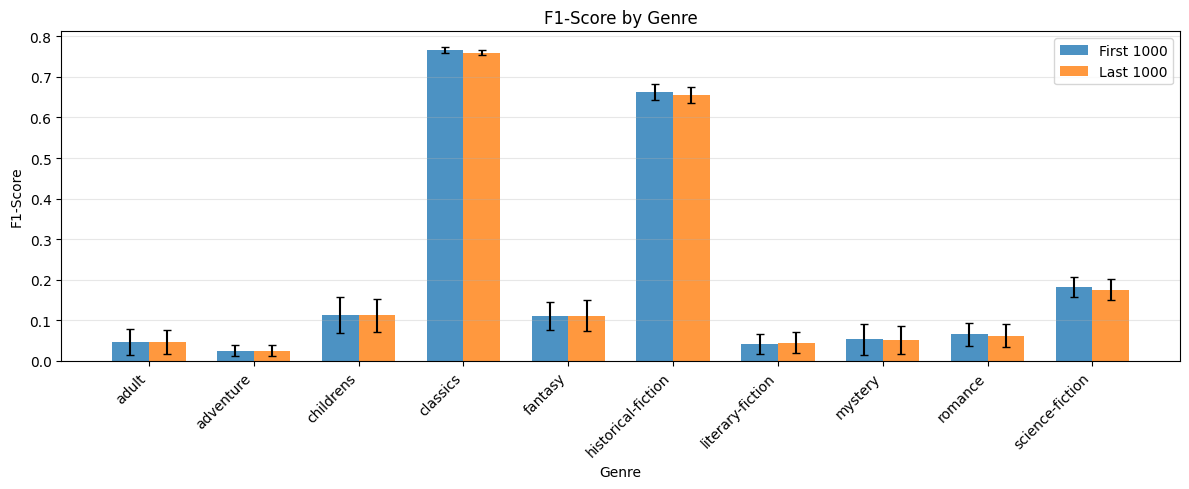

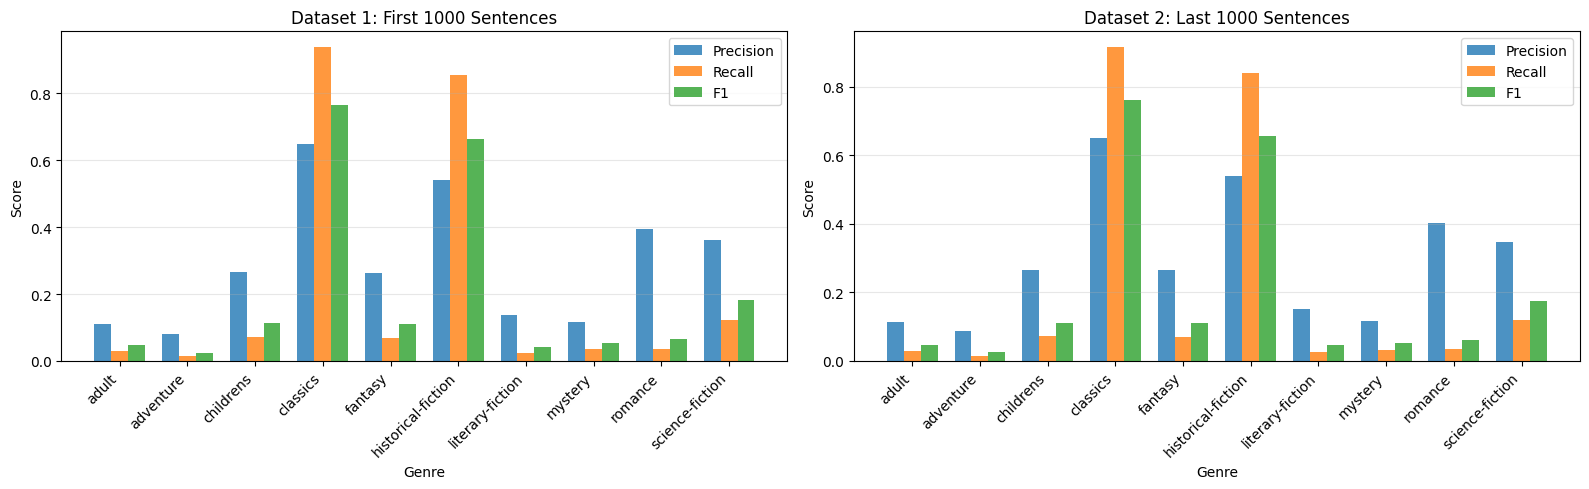

In [102]:
# get data for plots
genres = list(genre_names)

d1_f1_means = [dataset1_aggregated[g]['f1_mean'] for g in genres]
d1_f1_stds = [dataset1_aggregated[g]['f1_std'] for g in genres]
d1_precision_means = [dataset1_aggregated[g]['precision_mean'] for g in genres]
d1_recall_means = [dataset1_aggregated[g]['recall_mean'] for g in genres]

d2_f1_means = [dataset2_aggregated[g]['f1_mean'] for g in genres]
d2_f1_stds = [dataset2_aggregated[g]['f1_std'] for g in genres]
d2_precision_means = [dataset2_aggregated[g]['precision_mean'] for g in genres]
d2_recall_means = [dataset2_aggregated[g]['recall_mean'] for g in genres]

# Plot 1: F1 comparison
fig, ax = plt.subplots(figsize=(12, 5))
x = np.arange(len(genres))
width = 0.35

ax.bar(x - width/2, d1_f1_means, width, yerr=d1_f1_stds,
       label='First 1000', alpha=0.8, capsize=3)
ax.bar(x + width/2, d2_f1_means, width, yerr=d2_f1_stds,
       label='Last 1000', alpha=0.8, capsize=3)

ax.set_xlabel('Genre')
ax.set_ylabel('F1-Score')
ax.set_title('F1-Score by Genre')
ax.set_xticks(x)
ax.set_xticklabels(genres, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Side by side metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
x = np.arange(len(genres))
width = 0.25

# Dataset 1
ax1.bar(x - width, d1_precision_means, width, label='Precision', alpha=0.8)
ax1.bar(x, d1_recall_means, width, label='Recall', alpha=0.8)
ax1.bar(x + width, d1_f1_means, width, label='F1', alpha=0.8)
ax1.set_xlabel('Genre')
ax1.set_ylabel('Score')
ax1.set_title('Dataset 1: First 1000 Sentences')
ax1.set_xticks(x)
ax1.set_xticklabels(genres, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Dataset 2
ax2.bar(x - width, d2_precision_means, width, label='Precision', alpha=0.8)
ax2.bar(x, d2_recall_means, width, label='Recall', alpha=0.8)
ax2.bar(x + width, d2_f1_means, width, label='F1', alpha=0.8)
ax2.set_xlabel('Genre')
ax2.set_ylabel('Score')
ax2.set_title('Dataset 2: Last 1000 Sentences')
ax2.set_xticks(x)
ax2.set_xticklabels(genres, rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

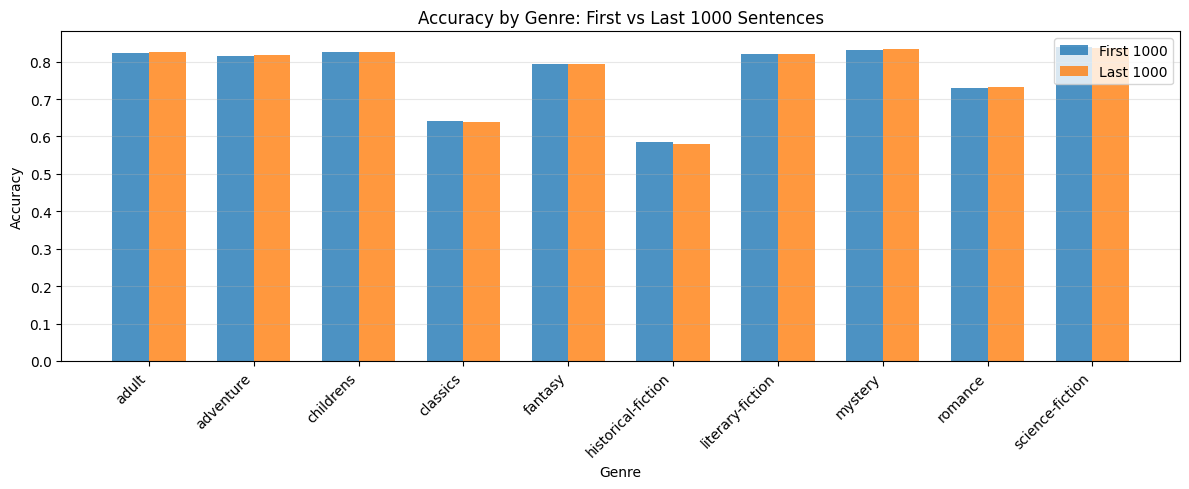

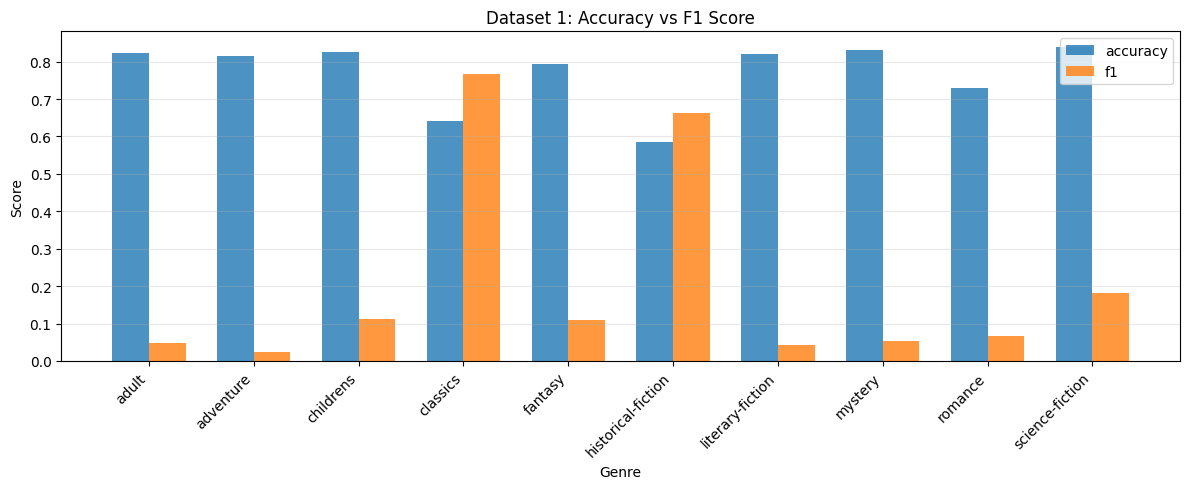

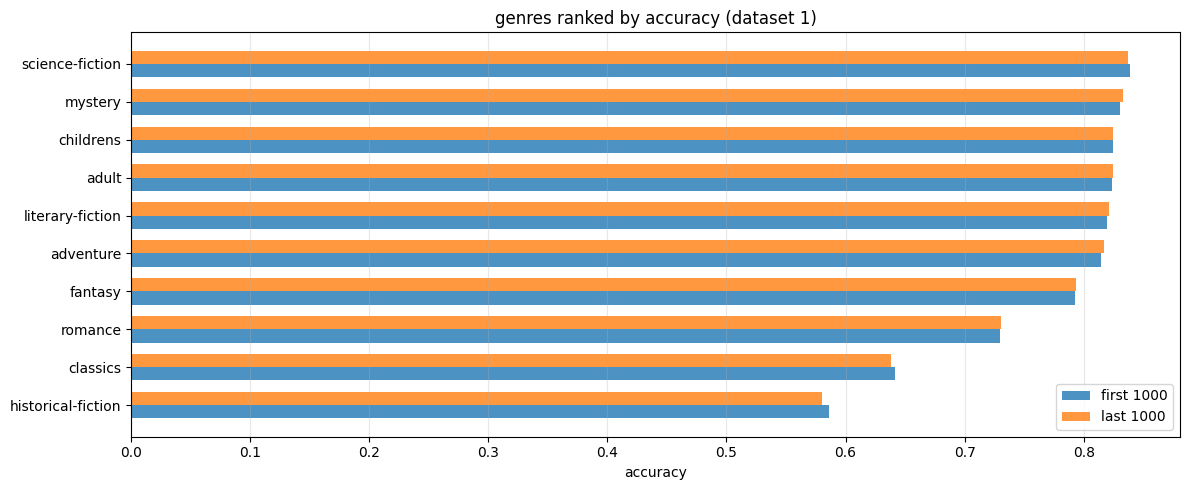

In [104]:
# accuracy comparison plots
d1_accuracy_means = [dataset1_aggregated[g]['accuracy_mean'] for g in genres]
d1_accuracy_stds = [dataset1_aggregated[g]['accuracy_std'] for g in genres]
d2_accuracy_means = [dataset2_aggregated[g]['accuracy_mean'] for g in genres]
d2_accuracy_stds = [dataset2_aggregated[g]['accuracy_std'] for g in genres]

# plot 1: accuracy comparison between first and last
fig, ax = plt.subplots(figsize=(12, 5))
x = np.arange(len(genres))
width = 0.35

ax.bar(x - width/2, d1_accuracy_means, width, 
       label='First 1000', alpha=0.8)
ax.bar(x + width/2, d2_accuracy_means, width, 
       label='Last 1000', alpha=0.8)

ax.set_xlabel('Genre')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Genre: First vs Last 1000 Sentences')
ax.set_xticks(x)
ax.set_xticklabels(genres, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# plot 2: accuracy vs f1 comparison for dataset 1
fig, ax = plt.subplots(figsize=(12, 5))
x = np.arange(len(genres))
width = 0.35

ax.bar(x - width/2, d1_accuracy_means, width, label='accuracy', alpha=0.8)
ax.bar(x + width/2, d1_f1_means, width, label='f1', alpha=0.8)

ax.set_xlabel('Genre')
ax.set_ylabel('Score')
ax.set_title('Dataset 1: Accuracy vs F1 Score')
ax.set_xticks(x)
ax.set_xticklabels(genres, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# plot 3: sorted by accuracy
sorted_indices = np.argsort(d1_accuracy_means)
sorted_genres = [genres[i] for i in sorted_indices]
sorted_acc_d1 = [d1_accuracy_means[i] for i in sorted_indices]
sorted_acc_d2 = [d2_accuracy_means[i] for i in sorted_indices]

fig, ax = plt.subplots(figsize=(12, 5))
x = np.arange(len(sorted_genres))
width = 0.35

ax.barh(x - width/2, sorted_acc_d1, width, label='first 1000', alpha=0.8)
ax.barh(x + width/2, sorted_acc_d2, width, label='last 1000', alpha=0.8)

ax.set_yticks(x)
ax.set_yticklabels(sorted_genres)
ax.set_xlabel('accuracy')
ax.set_title('genres ranked by accuracy (dataset 1)')
ax.legend()
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [84]:
# check label distribution
label_counts_1 = Y1.sum(axis=0)
for i, genre in enumerate(genre_names):
    print(f"  {genre}: {label_counts_1[i]} ({label_counts_1[i]/len(Y1)*100:.1f}%)")

  adult: 928 (14.7%)
  adventure: 1012 (16.0%)
  childrens: 990 (15.6%)
  classics: 3963 (62.6%)
  fantasy: 1161 (18.3%)
  historical-fiction: 3025 (47.8%)
  literary-fiction: 1012 (16.0%)
  mystery: 865 (13.7%)
  romance: 1681 (26.5%)
  science-fiction: 927 (14.6%)


In [ ]:
# analyze top words for each genre classifier
def get_top_words_for_genre(X_combined, Y_labels, genre_names, genre_name, n_top=20):
    genre_idx = genre_names.index(genre_name)
    
    # train classifier on full dataset
    y_binary = Y_labels[:, genre_idx]
    clf = MultinomialNB(alpha=1.0)
    clf.fit(X_combined, y_binary)
    
    # get feature log probabilities (higher means more probable)
    log_probs = clf.feature_log_prob_[1]  # log probs for positive class
    
    # get top features (only from word counts)
    n_word_features = X1.shape[1]  # number of TF-IDF features
    top_indices = np.argsort(log_probs[:n_word_features])[-n_top:][::-1]

    # need to get feature names from the TfidfVectorizer by recreating it or loading the vocabulary
    return top_indices, log_probs[top_indices]

from sklearn.feature_extraction.text import TfidfVectorizer

# load the original data to get vocabulary
first_df_full = pd.read_parquet("cleaned_data_first.parquet")
vectorizer = TfidfVectorizer(max_features=50000, stop_words="english", ngram_range=(1,1))
vectorizer.fit(first_df_full["text"])
feature_names = vectorizer.get_feature_names_out()

print(f"Total vocabulary size: {len(feature_names)}")
print("\nTop 20 words for each genre:\n")

# analyze each genre
genre_top_words = {}
for genre in genre_names:
    top_indices, top_probs = get_top_words_for_genre(X1_combined, Y1, genre_names, genre, n_top=20)
    top_words = [feature_names[i] for i in top_indices]
    genre_top_words[genre] = list(zip(top_words, top_probs))
    
    print(f"{genre}:")
    for word, prob in genre_top_words[genre][:10]:
        print(f"  {word}: {prob:.4f}")
    print()

Total vocabulary size: 50000

Top 20 words for each genre:

adult:
  said: -12.5861
  man: -13.0678
  like: -13.1345
  little: -13.1881
  time: -13.3170
  know: -13.4206
  did: -13.4239
  old: -13.5123
  la: -13.5223
  mr: -13.5305

adventure:
  said: -12.5694
  man: -13.0701
  like: -13.2104
  little: -13.2311
  time: -13.3049
  did: -13.3884
  know: -13.5147
  old: -13.5383
  came: -13.5622
  good: -13.5645

childrens:
  said: -12.3444
  little: -12.7158
  illustration: -13.1444
  like: -13.1736
  time: -13.2707
  old: -13.3216
  man: -13.3318
  did: -13.3327
  good: -13.3877
  came: -13.4123

classics:
  said: -12.6267
  man: -13.1388
  little: -13.1706
  like: -13.2234
  time: -13.3786
  did: -13.4615
  old: -13.5126
  know: -13.5344
  mr: -13.5912
  good: -13.5993

fantasy:
  said: -12.4652
  man: -13.0677
  like: -13.0800
  little: -13.1157
  time: -13.2758
  did: -13.3801
  know: -13.4621
  old: -13.4780
  came: -13.4792
  great: -13.5398

historical-fiction:
  said: -12.7313
  

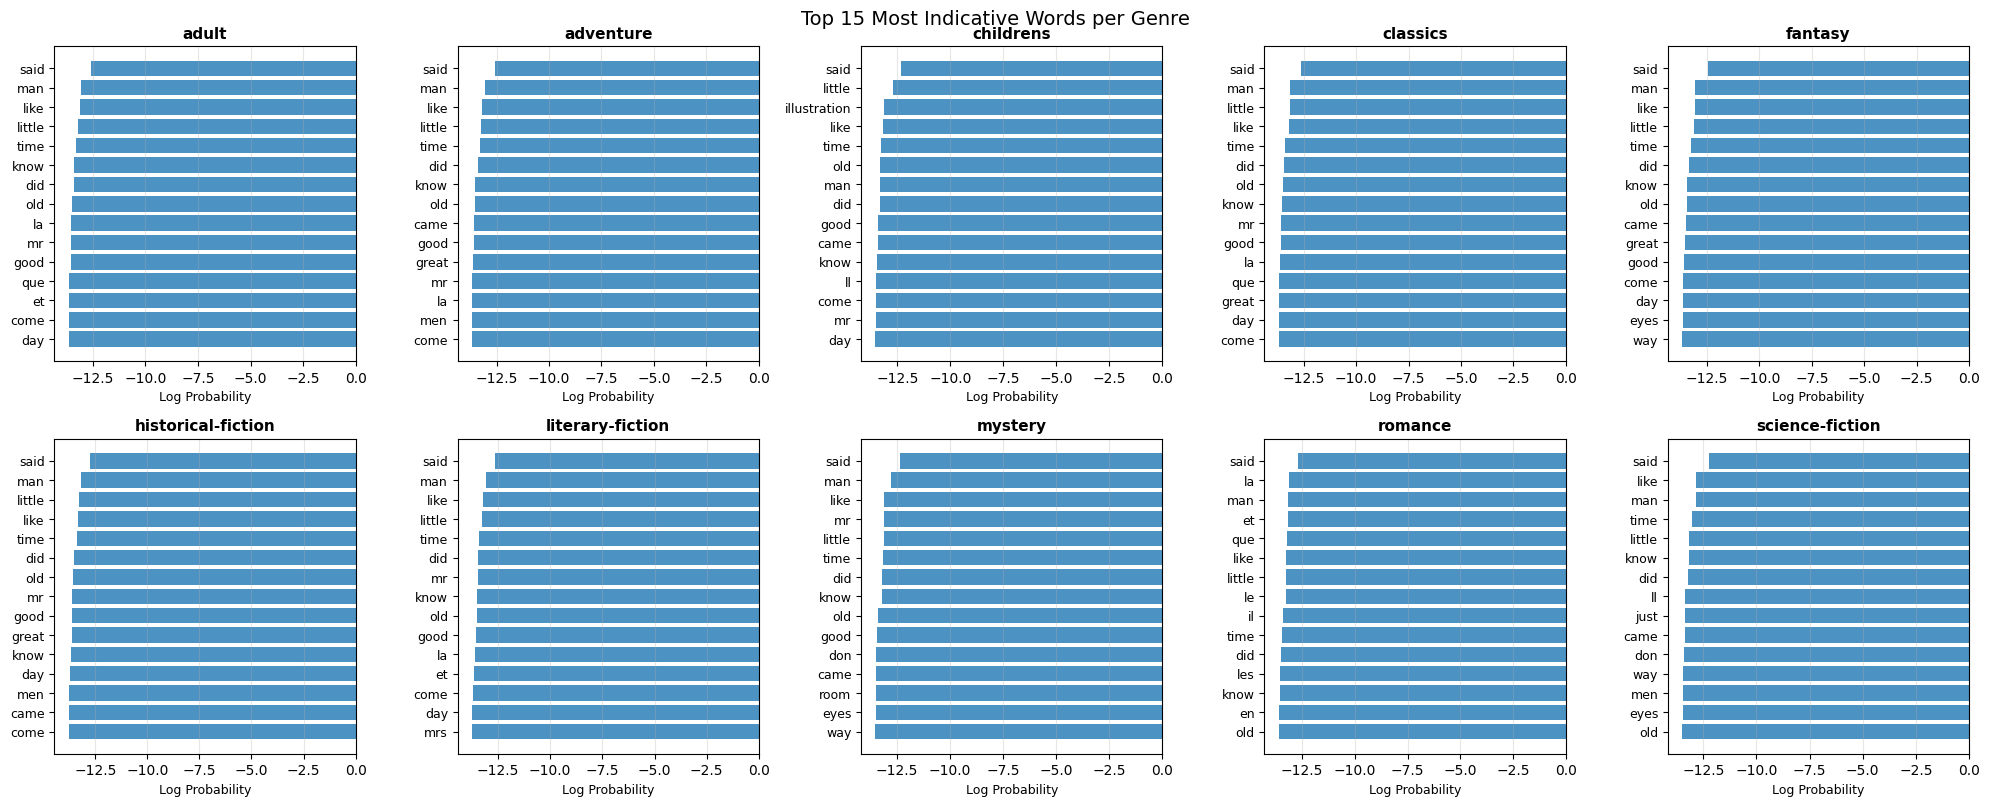

In [86]:
# visualize top words for each genre
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, genre in enumerate(genre_names):
    words = [w for w, _ in genre_top_words[genre][:15]]
    probs = [p for _, p in genre_top_words[genre][:15]]
    
    ax = axes[idx]
    y_pos = np.arange(len(words))
    
    ax.barh(y_pos, probs, alpha=0.8)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(words, fontsize=9)
    ax.invert_yaxis()
    ax.set_xlabel('Log Probability', fontsize=9)
    ax.set_title(f'{genre}', fontsize=11, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.suptitle('Top 15 Most Indicative Words per Genre', fontsize=14, y=1.002)
plt.show()